In [2]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['CO2_Renew_Life_DB']
collection = db['carbon_emissions']

# Fetch data from MongoDB
emission_data = list(collection.find())

df= pd.DataFrame(emission_data)

print("Data Overview:")
print(df.head())
print("\nData Description:")
print(df.info())

Data Overview:
                        _id       Entity  Year  \
0  67f7a0167e2e5f9fbc725dd3  Afghanistan  1949   
1  67f7a0167e2e5f9fbc725dd4  Afghanistan  1950   
2  67f7a0167e2e5f9fbc725dd5  Afghanistan  1951   
3  67f7a0167e2e5f9fbc725dd6  Afghanistan  1952   
4  67f7a0167e2e5f9fbc725dd7  Afghanistan  1953   

   Annual CO₂ emissions (per capita)  
0                           0.001992  
1                           0.010837  
2                           0.011625  
3                           0.011468  
4                           0.013123  

Data Description:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52364 entries, 0 to 52363
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _id                                52364 non-null  object 
 1   Entity                             52364 non-null  object 
 2   Year                               52364 non-null  int64  
 3 

# Cleaning the Data

In [4]:
if '_id' in df.columns:
    df = df.drop('_id', axis=1)

In [5]:
#Clean the year column
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64') #Int64 prevents NaN conversion to float

# Conerting emission columns to float
df['Annual CO₂ emissions (per capita)'] = pd.to_numeric(df['Annual CO₂ emissions (per capita)'], errors='coerce').astype('float')

#Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])

# removing rows with missing emissions data
df = df.dropna(subset=['Annual CO₂ emissions (per capita)'])

# Handle Negative Values
df = df[df['Annual CO₂ emissions (per capita)'] >= 0]

# Check for duplicates
duplicates = df.duplicated().sum()
print("\nDuplicates:")
print(duplicates)

# Remove duplicates if any
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows.")
else:
    print("No duplicates found.")   

# Check for outliers using IQR method   
Q1 = df['Annual CO₂ emissions (per capita)'].quantile(0.25)
Q3 = df['Annual CO₂ emissions (per capita)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR    
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['Annual CO₂ emissions (per capita)'] < lower_bound) | (df['Annual CO₂ emissions (per capita)'] > upper_bound)]
print("\nOutliers:")
print(outliers.shape[0])

# Remove outliers
df = df[~df.index.isin(outliers.index)]
print(f"Removed {outliers.shape[0]} outlier rows.")



Missing Values:
Series([], dtype: int64)

Duplicates:
26182
Removed 26182 duplicate rows.

Outliers:
2118
Removed 2118 outlier rows.


# Visualization of Cleaned Data

C:\Users\aryam\AppData\Local\Temp\ipykernel_13692\2912650261.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Year', y='Annual CO₂ emissions (per capita)', data=df.sample(1000), palette='Set2')


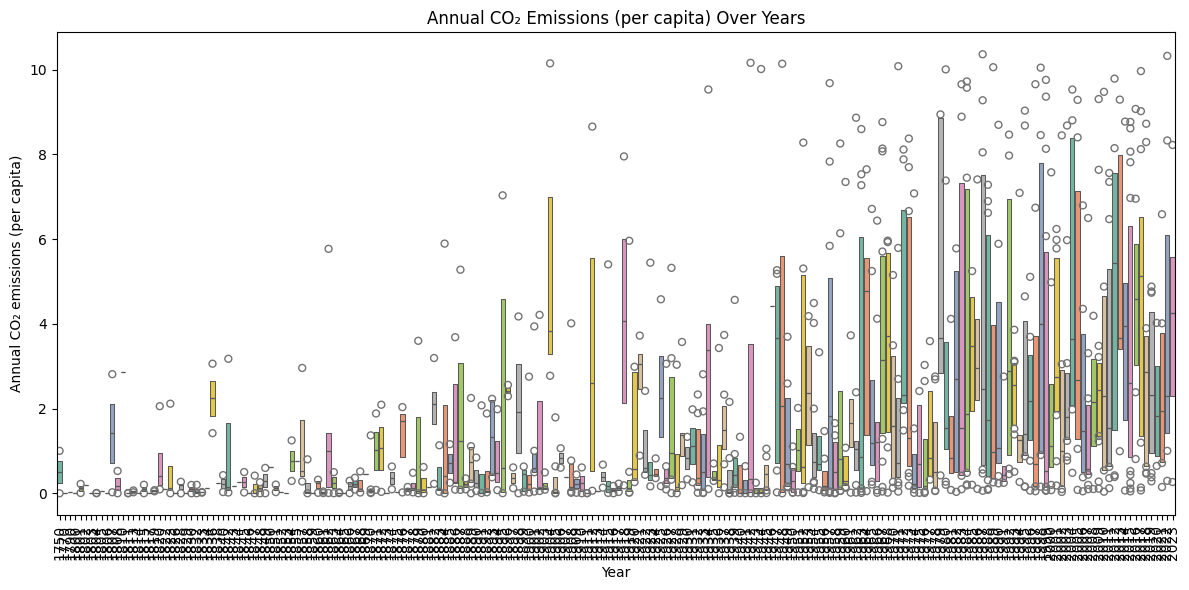

In [9]:
plt.figure(figsize=(12, 6))
sns.boxenplot(x='Year', y='Annual CO₂ emissions (per capita)', data=df.sample(1000), palette='Set2')
plt.xticks(rotation=90)
plt.title('Annual CO₂ Emissions (per capita) Over Years')
plt.tight_layout()
plt.show()  


C:\Users\aryam\AppData\Local\Temp\ipykernel_13692\242898230.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Entity', y='Annual CO₂ emissions (per capita)', data=top_10_countries, palette='Set2')


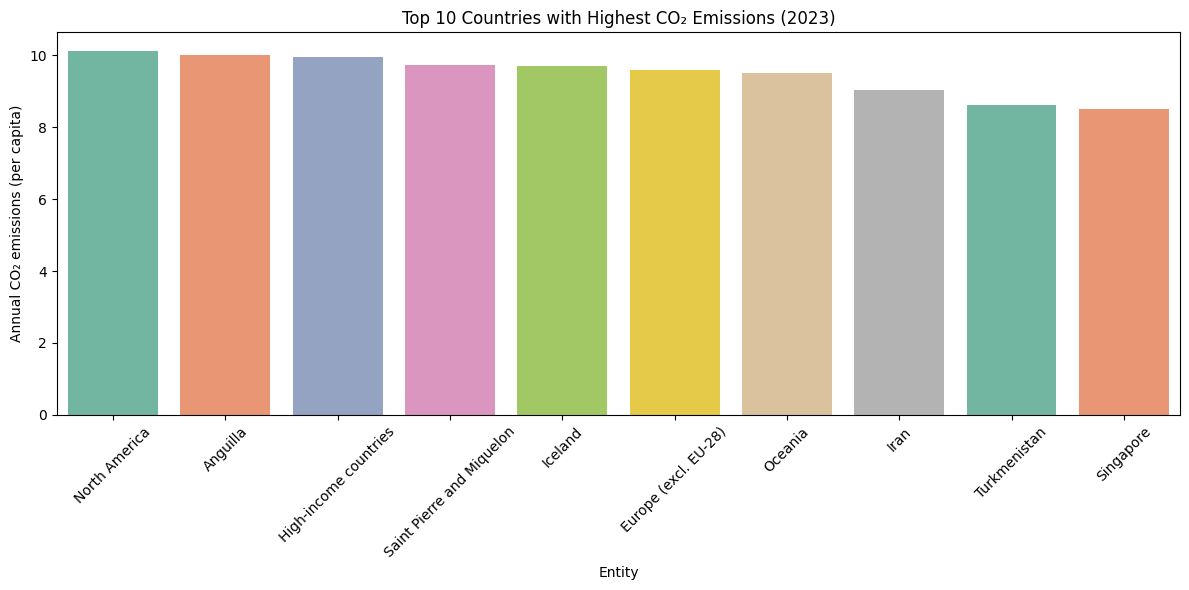

In [11]:
# plot of top 10 countries with highest emissions in 2023
top_10_countries = df[df['Year'] == 2023].nlargest(10, 'Annual CO₂ emissions (per capita)')
plt.figure(figsize=(12, 6)) 
sns.barplot(x='Entity', y='Annual CO₂ emissions (per capita)', data=top_10_countries, palette='Set2')
plt.xticks(rotation=45)
plt.title('Top 10 Countries with Highest CO₂ Emissions (2023)')
plt.tight_layout()
plt.show()

# Saving Cleaned data in MongoDB

In [15]:
# Save cleaned data to MongoDB
collection = db['cleaned_carbon_emissions']
collection.drop()  # Drop the collection if it exists
collection.insert_many(df.to_dict('records'))
print("Cleaned data saved to MongoDB in 'cleaned_carbon_emissions' collection.")


Cleaned data saved to MongoDB in 'cleaned_carbon_emissions' collection.


In [ ]:
#show the cleaned data numbers
print("\nCleaned Data Shape:")
print(df.shape)


Cleaned Data Shape:
(24064, 3)

Cleaned Data Overview:
        Entity  Year  Annual CO₂ emissions (per capita)
0  Afghanistan  1949                           0.001992
1  Afghanistan  1950                           0.010837
2  Afghanistan  1951                           0.011625
3  Afghanistan  1952                           0.011468
4  Afghanistan  1953                           0.013123

Cleaned Data Description:
